In [12]:
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


def timeit(f):

    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()

        print(f'func: {f.__name__} took: {te-ts:.4f} sec')
        return result

    return timed


def load_dataset(path):
    with open(path, 'rb') as f:
        train_data, test_data = pickle.load(f)
    
    X_train = torch.tensor(train_data[0], dtype=torch.float).unsqueeze(1)
    y_train = torch.tensor(train_data[1], dtype=torch.long)
    X_test = torch.tensor(test_data[0], dtype=torch.float).unsqueeze(1)
    y_test = torch.tensor(test_data[1], dtype=torch.long)
    return X_train, y_train, X_test, y_test


class MnistDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    

class Trainer:
    
    def __init__(self, model, opt_method, learning_rate, batch_size, epoch, l2):
        self.model = model
        if opt_method == "sgdm":
            self.optimizer = torch.optim.SGD(model.parameters(), learning_rate, momentum=0.9)
        elif opt_method == "adam":
            self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)
        else:
            raise NotImplementedError("This optimization is not supported")
        
        self.epoch = epoch
        self.batch_size = batch_size
    
    @timeit
    def train(self, train_data, val_data, early_stop=True, verbose=True, draw_curve=True):
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        
        train_loss_list, train_acc_list = [], []
        val_loss_list, val_acc_list = [], []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        loss_func = nn.CrossEntropyLoss()
        for n in tqdm(range(self.epoch), leave=False):
            self.model.train()
            for X_batch, y_batch in train_loader:
                y_pred = self.model(X_batch)
                batch_loss = loss_func(y_pred, y_batch)
                
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
            train_loss, train_acc = self.evaluate(train_data)
            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)
            
            val_loss, val_acc = self.evaluate(val_data)
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)
            
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
            
        if draw_curve:
            x_axis = np.arange(self.epoch)
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            axes[0].plot(x_axis, train_loss_list, label="Train")
            axes[0].plot(x_axis, val_loss_list, label="Validation")
            axes[0].set_title("Loss")
            axes[0].legend()
            axes[1].plot(x_axis, train_acc_list, label='Train')
            axes[1].plot(x_axis, val_acc_list, label='Validation')
            axes[1].set_title("Accuracy")
            axes[1].legend()
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return {
            "train_loss_list": train_loss_list,
            "train_acc_list": train_acc_list,
            "val_loss_list": val_loss_list,
            "val_acc_list": val_acc_list,
        }
    
    def evaluate(self, data, print_acc=False):
        self.model.eval()
        loader = DataLoader(data, batch_size=self.batch_size, shuffle=True)
        loss_func = nn.CrossEntropyLoss()
        acc, loss = 0.0, 0.0
        for X_batch, y_batch in loader:
            with torch.no_grad():
                batch_importance = y_batch.shape[0] / len(data)
                y_pred = self.model(X_batch)
                batch_loss = loss_func(y_pred, y_batch)
                batch_acc = torch.sum(torch.argmax(y_pred, axis=-1) == y_batch) / y_batch.shape[0]
                acc += batch_acc.detach().cpu().item() * batch_importance
                loss += batch_loss.detach().cpu().item() * batch_importance
        if print_acc:
            print(f"Accuracy: {acc:.3f}")
        return loss, acc
    

def KFoldCrossValidation(
    model_class, k, 
    X_train, y_train, X_test, y_test, 
    opt_method='adam', learning_rate=2e-3, batch_size=128, epoch=50, l2=0.0,
    early_break=False,
    **model_args
):
    test_data = MnistDataset(X_test, y_test)
    kf = KFold(n_splits=k, shuffle=True)
    train_acc_list, test_acc_list = [], []
    for i, (train_index, val_index) in enumerate(kf.split(X_train)):
        print(f"Fold {i}:")
        
        train_data = MnistDataset(X_train[train_index], y_train[train_index])
        val_data = MnistDataset(X_train[val_index], y_train[val_index])
        
        model = model_class(**model_args)
        
        trainer = Trainer(model, opt_method, learning_rate, batch_size, epoch, l2)
        res = trainer.train(train_data, val_data)
        train_acc_best = res['train_acc_list'][np.argmin(res['val_loss_list'])]
        test_loss, test_acc = trainer.evaluate(test_data)
        
        train_acc_list.append(train_acc_best)
        test_acc_list.append(test_acc)
        
        print(f"Training accuracy: {train_acc_best}")
        print(f"Test accuracy: {test_acc}")
        
        if early_break:
            break
    
    if not early_break:
        print("Final results:")
        print(f"Training accuracy: {np.mean(train_acc_list)}+/-{np.std(train_acc_list)}")
        print(f"Test accuracy: {np.mean(test_acc_list)}+/-{np.std(test_acc_list)}")


In [13]:
X_train, y_train, X_test, y_test = load_dataset("mnist.pkl")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: torch.Size([60000, 1, 32, 32])
X_test shape: torch.Size([10000, 1, 32, 32])
y_train shape: torch.Size([60000])
y_test shape: torch.Size([10000])


# Question 1

### For (a) and (b), DO NOT use `torchsummary` package. Please calculate by yourself. 

## (a)

Using the equation **(W−F+2P)/S+1** to determine the output volume of a convolutional layer, with 
* W = dimensions of the input (in 2D, the width and height)
* F = dimensions of our filter (the convolutional filter)
* P = size of padding layer
* S = size of stride

This is the dimension of an output from *one filter*, meaning for n filters, the total dimensionality of the output would be **n(W−F+2P)/S+1** 

### (i)

Our MNIST dataset contains images of dimension (32, 32). Our filter dimension is (2x2), the number of filters is 33, and our stride is 2 with padding of 0.

Plugging this into our equation for output dimensionality:

$$ ( 32 - 2 + 2(0) ) / 2 + 1 = 16 $$ 

For 33 filters, the output will be of dimension **(16, 16, 33)**




### (ii)

Applying the convolutions sequentially, our output from (i) will be our new input for the convolutional layer in (ii). Thus, our input dimension will be (16, 16, 33).

n = 55 \
W = 16 \
F = 3 \
S = 1 \
P = 1

$$ (16 - 3 + 2(1)) / 1 + 1 = 16 $$ 

Because we have 55 filters, there will be 55 filters for each convolutional, leading to a final output dimension of 

**(16, 16, 55)**

### (iii)

Once again, the output from (ii) will be our new input.

n = 77 \
W = 16 \
F = 3 \
S = 1 \
P = 1 

$$ (16 - 3 + 2(1)) / 1 + 1 = 16 $$ 

The output of the convolution with 77 filters would thus be (16, 16, 77). 

After Max Pooling with a filter of size (2, 2) and stride 2, the final output dimension can also be calculated using the same equation, since pooling is essentially just applying a filter of the size of the pooling.

n = 77 \
W = 16 \
F = 2 \
S = 2 \
P = 0 

$$ (16 - 2 + 2(0)) / 2 + 1 = 8 $$

So after pooling the final output dimension will be:

**(8, 8, 77)**

## (b)

We can use the same equation **(W−F+2P)/S+1** to determine the output volume of a convolutional layer. The output dimension of the convolution remains the same for an image with 3 color values instead of one, the only difference is now the convolution will take the sum across the 3 RGB values instead of just for the one black and white value. Essentially, it will take the dot product for the 3D matrix with the weight vector, instead of just the 1D matrix. 
* W = dimensions of the input (in 2D, the width and height)
* F = dimensions of our filter (the convolutional filter)
* P = size of padding layer
* S = size of stride

This is the dimension of an output from *one filter*, meaning for n filters, the total dimensionality of the output would be **n(W−F+2P)/S+1** 

### (i)

Our MNIST dataset contains images of dimension (32, 32). Our filter dimension is (2x2), the number of filters is 33, and our stride is 2 with padding of 0.

Plugging this into our equation for output dimensionality:

$$ ( 32 - 2 + 2(0) ) / 2 + 1 = 16 $$ 

For 33 filters, the output will be of dimension **(16, 16, 33)**

This is the same as 1ai. 



### (ii)

Applying the convolutions sequentially, our output from (i) will be our new input for the convolutional layer in (ii). Thus, our input dimension will be (16, 16, 33).

n = 55 \
W = 16 \
F = 3 \
S = 1 \
P = 1

$$ (16 - 3 + 2(1)) / 1 + 1 = 16 $$ 

Because we have 55 filters, there will be 55 filters for each convolutional, leading to an output dimension of (16, 16, 55) from the convolutional layer.

After Max Pooling with a filter of size (3, 3) and stride 1,  and pooling of 0, the final output dimension can also be calculated using the same equation, since pooling is essentially just applying a filter of the size of the pooling.

n = 55 \
W = 16 \
F = 3 \
S = 1 \
P = 0 

$$ (16 - 3 + 2(0)) / 1 + 1 = 14 $$

So after pooling the final output dimension will be:

**(14, 14, 55)**

### (iii)

Once again, the output from (ii) will be our new input.
(14, 14, 55)

n = 77 \
W = 14 \
F = 3 \
S = 1 \
P = 1 

$$ (14 - 3 + 2(1)) / 1 + 1 =  14$$ 

The output of the convolution with 77 filters would thus be (14, 14, 77). 

After Max Pooling with a filter of size (2, 2) and stride 2, padding of 0, the final output dimension can also be calculated using the same equation, since pooling is essentially just applying a filter of the size of the pooling.

n = 77 \
W = 14 \
F = 2 \
S = 2 \
P = 0 

$$ (14 - 2 + 2(0)) / 2 + 1 = 7 $$

So after pooling the final output dimension will be:

**(7, 7, 77)**

## (c)

### Instructions: For training stability, it is recommened to normalize the data by dividing its max value as you did in HW6.

In [14]:
X_train, y_train, X_test, y_test = load_dataset("mnist.pkl")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: torch.Size([60000, 1, 32, 32])
X_test shape: torch.Size([10000, 1, 32, 32])
y_train shape: torch.Size([60000])
y_test shape: torch.Size([10000])


In [15]:
# Normalize data
# X_train, y_train, X_test, y_test = load_dataset("mnist.pkl")
X_train /= torch.max(X_train)
X_test /= torch.max(X_test)

In [16]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: torch.Size([60000, 1, 32, 32])
X_test shape: torch.Size([10000, 1, 32, 32])


Fold 0:


  0%|          | 0/30 [00:00<?, ?it/s]

func: train took: 119.5863 sec
Training accuracy: 0.5842500000000007
Test accuracy: 0.5777999999999999
Fold 1:


func: train took: 110.6591 sec
Training accuracy: 0.6030500000000011
Test accuracy: 0.5932999999999998
Fold 2:


func: train took: 116.0155 sec
Training accuracy: 0.6033000000000002
Test accuracy: 0.6007999999999999
Final results:
Training accuracy: 0.5968666666666673+/-0.008921914343657127
Test accuracy: 0.5906333333333332+/-0.00957717193237243


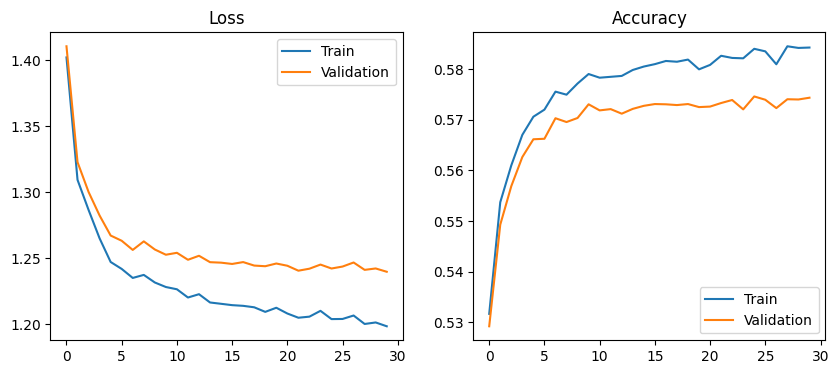

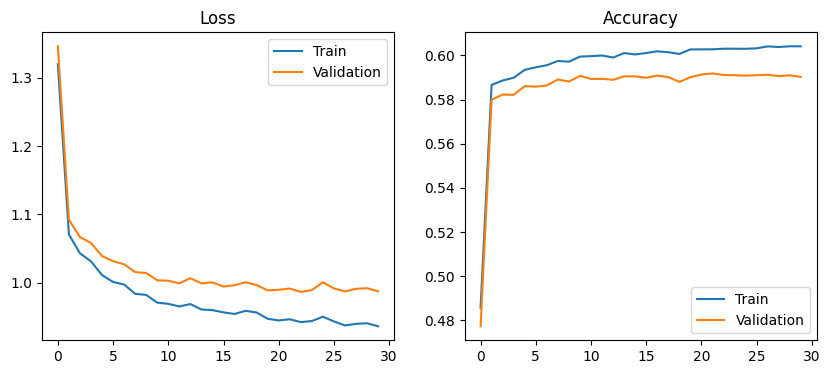

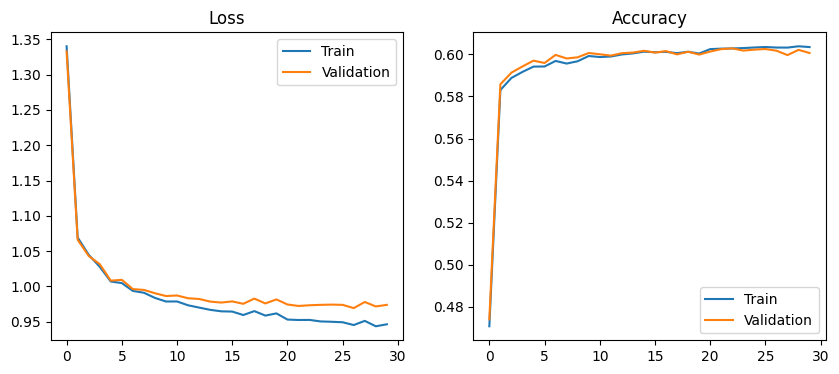

In [27]:
class ShallowCNN(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels=3, kernel_size=5, stride=1, padding=2)
        self.activation = nn.ReLU()
        self.fc = nn.Linear(3072, 10)

    def forward(self, x):
        #  print(x.size())
         x = nn.Flatten()(self.activation(self.conv(x)))
        #  x = self.activation(self.conv(x))
         x = self.activation(self.fc(x))
         return x
    
model = ShallowCNN()
KFoldCrossValidation(ShallowCNN, 
                     k=3,
                     X_train=X_train, 
                     y_train=y_train, 
                     X_test=X_test, 
                     y_test=y_test,
                     opt_method='adam', 
                     learning_rate=1e-3, 
                     batch_size=128, 
                     epoch=30, 
                     l2=0.0
                    )

## (d)

Fold 0:


  0%|          | 0/30 [00:00<?, ?it/s]

func: train took: 400.0460 sec
Training accuracy: 0.9975749999999978
Test accuracy: 0.9891000000000005
Fold 1:


func: train took: 401.2547 sec
Training accuracy: 0.9968249999999984
Test accuracy: 0.9905000000000008
Fold 2:


func: train took: 397.2989 sec
Training accuracy: 0.9977499999999982
Test accuracy: 0.9882000000000005
Final results:
Training accuracy: 0.9973833333333314+/-0.00040121343724020794
Test accuracy: 0.9892666666666673+/-0.0009463379711053564


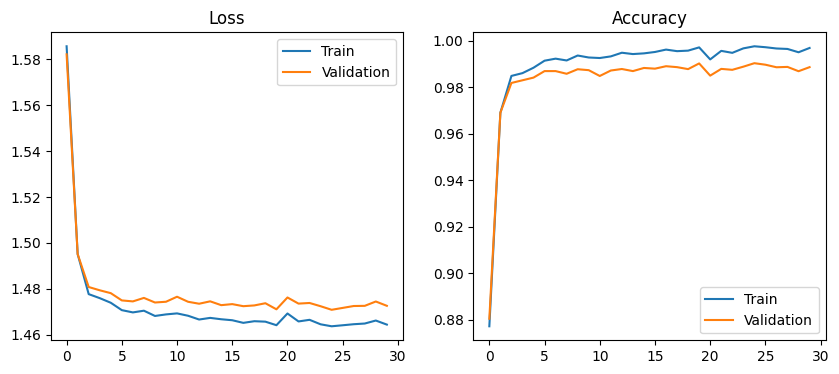

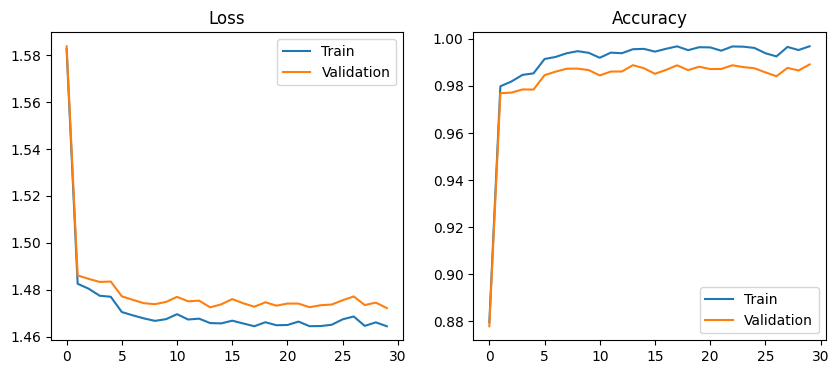

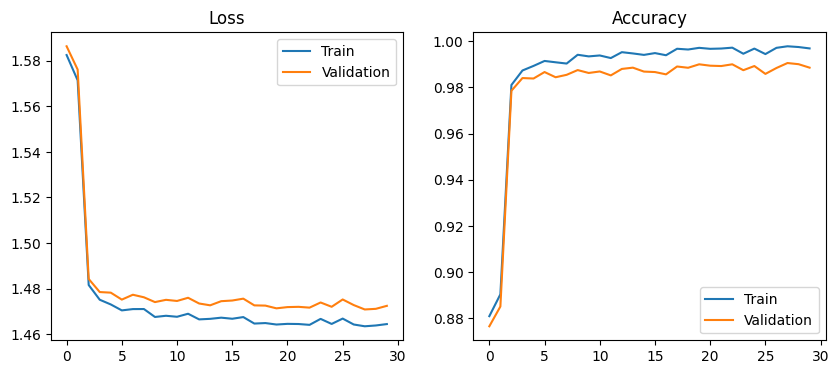

In [112]:
class DeepCNN(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.conv = nn.ModuleList([
            nn.Conv2d(in_channels, 6, kernel_size=6, stride=1, padding=1),
            nn.Conv2d(6, 120, kernel_size=5, stride=1),
        ])
        self.pool = nn.MaxPool2d(2)
        self.activation = nn.ReLU()
        self.fc = nn.ModuleList([
            nn.Linear(3000, 256),
            nn.Linear(256, 10)
        ])

    def forward(self, x):
        for i in range(2):
            x = self.pool(self.activation(self.conv[i](x)))
        x = nn.Flatten()(x)
        # print(x.size())
        x = self.activation(self.fc[0](x))
        x = nn.Softmax(dim=-1)(self.fc[1](x))
        return x

KFoldCrossValidation(DeepCNN, 
                     k=3,
                     X_train=X_train, 
                     y_train=y_train, 
                     X_test=X_test, 
                     y_test=y_test,
                     opt_method='adam', 
                     learning_rate=1e-3, 
                     batch_size=128, 
                     epoch=30, 
                     l2=0.0,
                    #  early_break=True
                    )

The average test accuracy was 0.9892666666666673+/-0.0009463379711053564! Successfully got over 98.5%!

# Question 2

### Instructions: You can set `early_break=True` in `KFoldCrossValidation` function to just to a train-validation round instead of doing 3-fold.

## (a)


In [90]:
def calc_out_dim(in_dim, kernel_size, padding, stride):
    return (in_dim - kernel_size + 2 * padding) // stride + 1

calc_out_dim(calc_out_dim(32, 3, 1, 1), 2, 0, 2)

16

From a 14x14 input feature map, want to convolve so that the output is 5x5. 

Use Kernel = 6, Padding = 0, Stride = 2


In [109]:
calc_out_dim(calc_out_dim(16, 4, 3, 2), 2, 0, 2)

5

Fold 0:


  0%|          | 0/30 [00:00<?, ?it/s]

func: train took: 658.6235 sec
Training accuracy: 0.9921499999999993
Test accuracy: 0.9842999999999996


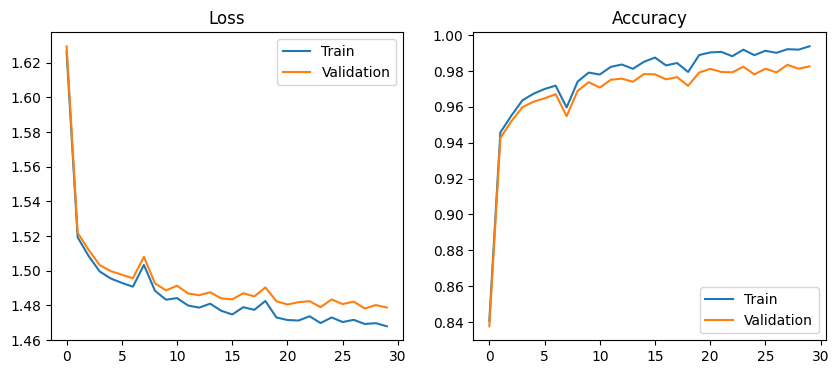

In [113]:
class ResNN(nn.Module):
    def __init__(self, in_channels=1, batch_norm=False):
        super().__init__()
        self.conv = nn.ModuleList([
            nn.Conv2d(in_channels, 16, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(16, 12, kernel_size=4, stride=2, padding=3),
        ])
        self.pool = nn.MaxPool2d(2)
        self.activation = nn.ReLU()
        self.fc = nn.ModuleList([
            nn.Linear(300, 300),
            nn.Linear(300, 10)
        ])
        self.batch_norm=batch_norm
        self.bn = nn.ModuleList([
            nn.BatchNorm2d(16),
            nn.BatchNorm2d(12),
        ])

    def forward(self, x):
        # print(x.size())
        for i in range(2):
            x = self.conv[i](x)
            if self.batch_norm:
                x = self.bn[i](x)
            x = self.pool(self.activation(x))
        x = nn.Flatten()(x)
        # print(x.size())
        x = self.activation(self.fc[0](x))
        x = nn.Softmax(dim=-1)(self.fc[1](x))
        return x

KFoldCrossValidation(ResNN, 
                     k=3,
                     X_train=X_train, 
                     y_train=y_train, 
                     X_test=X_test, 
                     y_test=y_test,
                     opt_method='adam', 
                     learning_rate=1e-3, 
                     batch_size=128, 
                     epoch=30, 
                     l2=0.0,
                     early_break=True
                    )

Fold 0:


func: train took: 642.9819 sec
Training accuracy: 0.9955499999999994
Test accuracy: 0.9868999999999999


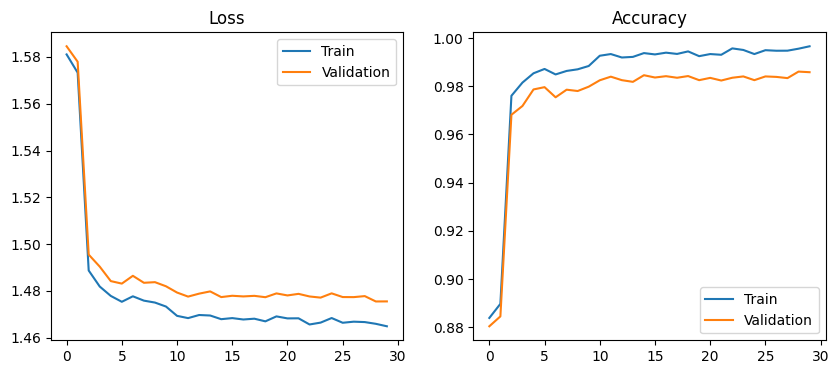

In [114]:
class ResNNBN(nn.Module):
    def __init__(self, in_channels=1, batch_norm=True):
        super().__init__()
        self.conv = nn.ModuleList([
            nn.Conv2d(in_channels, 16, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(16, 12, kernel_size=4, stride=2, padding=3),
        ])
        self.pool = nn.MaxPool2d(2)
        self.activation = nn.ReLU()
        self.fc = nn.ModuleList([
            nn.Linear(300, 300),
            nn.Linear(300, 10)
        ])
        self.batch_norm=batch_norm
        self.bn = nn.ModuleList([
            nn.BatchNorm2d(16),
            nn.BatchNorm2d(12),
        ])

    def forward(self, x):
        # print(x.size())
        for i in range(2):
            x = self.conv[i](x)
            if self.batch_norm:
                x = self.bn[i](x)
            x = self.pool(self.activation(x))
        x = nn.Flatten()(x)
        # print(x.size())
        x = self.activation(self.fc[0](x))
        x = nn.Softmax(dim=-1)(self.fc[1](x))
        return x

KFoldCrossValidation(ResNNBN, 
                     k=3,
                     X_train=X_train, 
                     y_train=y_train, 
                     X_test=X_test, 
                     y_test=y_test,
                     opt_method='adam', 
                     learning_rate=1e-3, 
                     batch_size=128, 
                     epoch=30, 
                     l2=0.0,
                     early_break=True
                    )

Batch normalization increases our testing accuracy!

## (b)

Fold 0:


  0%|          | 0/10 [00:00<?, ?it/s]

func: train took: 201.8856 sec
Training accuracy: 0.9736750000000015
Test accuracy: 0.9725999999999997


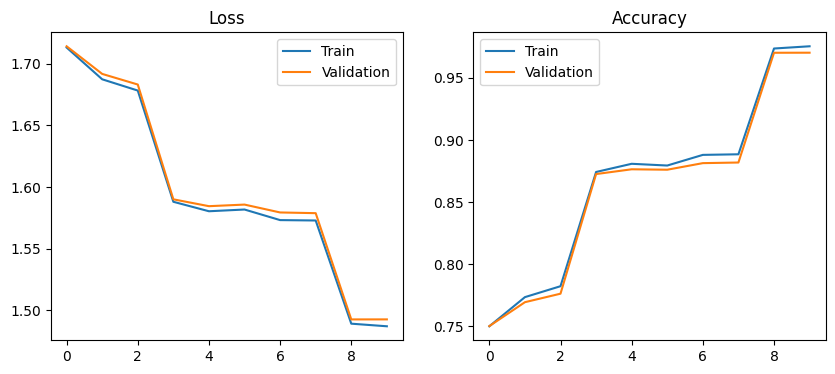

In [116]:
class ResNNSkip(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.conv = nn.ModuleList([
            nn.Conv2d(in_channels, 16, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(16, 12, kernel_size=4, stride=2, padding=3),
        ])
        self.pool = nn.MaxPool2d(2)
        self.activation = nn.ReLU()
        self.fc = nn.ModuleList([
            nn.Linear(300, 300),
            nn.Linear(300, 10)
        ])

    def forward(self, x):
        # print(x.size())
        for i in range(2):
            x = self.conv[i](x)
            x = self.pool(self.activation(x))
        x = nn.Flatten()(x)
        # print(x.size())
        skip = x
        x = self.activation(self.fc[0](x)) + skip
        x = nn.Softmax(dim=-1)(self.fc[1](x))
        return x

KFoldCrossValidation(ResNNSkip, 
                     k=3,
                     X_train=X_train, 
                     y_train=y_train, 
                     X_test=X_test, 
                     y_test=y_test,
                     opt_method='adam', 
                     learning_rate=1e-3, 
                     batch_size=128, 
                     epoch=10, 
                     l2=0.0,
                     early_break=True
                    )

After adding a skip connection, we see an increase in testing accuracy. 